## Initialization

### Initialization

In [1]:
import sys
#sys.path.append('/Users/chandrasekharmukherjee/Home/Centrality framework/Modules')
sys.path.append('I:/내 드라이브/backup/document/USC/Research/MCPC/Code/Codes')

#Import packages
#imports
import time
import pandas as pd
from collections import Counter
import sknetwork


from sknetwork.ranking import PageRank
from sknetwork.ranking import Betweenness
from sknetwork.ranking import Closeness

#import umap as umap

from numba.typed import List
import warnings
from numba import njit
import pynndescent
import numpy as np
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import operator
from sklearn.utils.extmath import randomized_svd
from random import randint
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
import scipy
#from umap.umap_ import *
import math
from random import randint
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.datasets import cifar100
from keras.datasets import fashion_mnist
import scanpy
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score, roc_auc_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

#import community as community_louvain
from sklearn.cluster import KMeans
from sklearn.metrics import fowlkes_mallows_score

import scipy

import igraph 
import networkx as nx


import metric as met 
import embedding as embed   
import data_utils_ch as data_util

%load_ext autoreload
%autoreload 2
import importlib

import metric as met 
import embedding as embed   
import data_utils_ch as data_util


met=importlib.reload(met)
embed=importlib.reload(embed)
data_util=importlib.reload(data_util)

### Get edge Lists

In [ ]:
#This is to get the edge_lists.

#scRNA datasets
datanames=['Zhengmix8eq']
for name in datanames:
    edge_list,vlist,n,label=data_util.local_SCRNA(name)
    print("Dataset names is ",name," |V|, |E| #clusters= ",n,len(edge_list),len(set(label)))


#These are for the bulk-RNA datasets.
datanames=['mRNA','miRNA']
for name in datanames:
    for survive in [0,1]:
        edge_list,vlist,label,n=data_util.local_bulkRNA(name,survive)
        label=data_util.set_labels(label)
        print("Dataset names is ",name," |V|, |E| #clusters= ",n,len(edge_list),len(set(label)))



#These contain image and document data.
#datanames=['FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups','biorxiv','big_patent']
datanames=['FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent']
for name in datanames:
    edge_list, label=data_util.load_data(name,kchoice=10)
    n=len(label)
    vlist=[i for i in range(n)]
    label=data_util.set_labels(label)

    print("Dataset names is ",name," |V|, |E| #clusters= ",n,len(edge_list),len(set(label)))


#These are data of 4 popular directed graphs. 
graphnames=['Cora','Cora full','Citeseer','Eu core']
for name in graphnames:
    edge_list,vlist,label,n,good_v=data_util.graph_database(name)
    label=data_util.set_labels(label)

    print("Dataset names is ",name," |V|, |E| #clusters= ",n,len(edge_list),len(set(label)))

### Raw Data

In [ ]:
#To get the raw data.

#scRNA datasets
datanames=['Zhengmix8eq']
for name in datanames:
    X,n,label=data_util.local_SCRNA(name,raw=1)



#These are for the bulk-RNA datasets.
datanames=['mRNA','miRNA']
for name in datanames:
    for survive in [0,1]:
        X,label,n=data_util.local_bulkRNA(name,survive)
        label=data_util.set_labels(label)



#These contain image and document data.
#datanames=['FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups','biorxiv','big_patent']
datanames=['FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','biorxiv','big_patent']
for name in datanames:
    X,label=data_util.load_data(name,raw=1)
    n=len(label)
    label=data_util.set_labels(label)






## Testing every dataset with top k % nodes induced subgraph (Louvain)

### Functions for Top k% induced Subgraph

In [6]:
import FlowRank_General as FR
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
def getInducedSubgraph(G, k, node2FR): #G = original graph, k = pick top k percent, node2FR = node to FR value
    #Get top k% nodes
    node_list = sorted(G.nodes, key=lambda x: node2FR[x], reverse=True)
    k = int(k*len(node_list))
    top_nodes = node_list[:k]
    #Remove nodes also remove adjacent edges
    H = G.copy()
    for u in G.nodes:
        if u not in top_nodes:
            H.remove_node(u)
    return H, node_list

def FlowRank_Func(edge_list,vlist,walk_len_c1,c_const=0,type=0):
    if type==0:
        return FR.FLOW(edge_list,vlist,walk_len_c1,c_const)
    elif type==1:
        return FR.FLOW_ng(edge_list,vlist,walk_len_c1,c_const)
    elif type==2:
        return FR.FLOW_ng_prop(edge_list,vlist,walk_len_c1,c_const)

def calc_FlowRank(graph, FR_type, walk_len_c1):
    node2FR = dict()
    if FR_type==3:
        pg_rank = nx.pagerank(graph,alpha=0.85) #alpha = 0.85 is the default
        node2FR = {k: pg_rank[k]*graph.number_of_nodes() for k in pg_rank}
    else:
        for i in FlowRank_Func(graph.edges(),graph.nodes(),walk_len_c1,0,FR_type):
            node_num = int(i[1])
            node2FR[node_num] = i[0]
    return node2FR

def part_to_compressed_label(partition,H,original_n): #partition to labels (Returns compressed labels)
    #Mapping node numbers to index
        
    label_1=[-1]*(original_n)
    c=0
    for sets in partition:
        for ell in sets:
            label_1[ell]=c
        
        c=c+1
    
    label_compressed = []
    #for i in sorted(H.nodes()):
    for i in H.nodes():
        if label_1[i] == -1: 
            print('Error: Node not found in partition')
            return None
        label_compressed.append(label_1[i])
    #print(label_compressed)
    return label_compressed

def part_to_full_label(partition, original_n): #partition to labels (Returns full labels)
    #Mapping node numbers to index
        
    label_1=[-1]*(original_n)
    c=0
    for sets in partition:
        for ell in sets:
            label_1[ell]=c
        
        c=c+1
    #print(label_compressed)
    return label_1

def get_NMI(H, partition, label, original_n):
    #Keep the labels of the nodes in subgraph G only
    new_label = []
    #for i in sorted(H.nodes()):
    for i in H.nodes():
        #print('node: ',i)
        new_label.append(label[i])
    #change the partition form {[node2,node4], [,...,]} to label form {[0,2,1,2,grp#,...]}
    part_label = part_to_compressed_label(partition,H, original_n)
    
    # arr = np.array(part_label)
    # arr = arr.flatten()
    # nmi = NMI(arr, new_label)

    nmi = NMI(part_label, new_label)
    return nmi

def get_NMI2(H_label, label):
    n = len(label)
    label_compressed = []
    for i in range(n):
        if H_label[i] != -1:
            label_compressed.append(label[i])
    
    H_label_compressed = []
    for i in range(n):
        if H_label[i] != -1:
            H_label_compressed.append(H_label[i])

    nmi_ = NMI(H_label_compressed, label_compressed)   
    #nmi_ = NMI(H_label_compressed, label_compressed)
    #print('nmi: ',nmi_, 'node #: ',len(H_label_compressed))
    return nmi_
        
def get_Purity(H, partition, label, original_n):
    #Keep the labels of the nodes in subgraph G only
    new_label = []
    #for i in sorted(H.nodes()):
    for i in H.nodes():
        #print('node: ',i)
        new_label.append(label[i])
    #change the partition form {[node2,node4], [,...,]} to label form {[0,2,1,2,grp#,...]}
    part_label = part_to_compressed_label(partition,H, original_n)
    
    arr = np.array(part_label)
    arr = arr.flatten()
    purity = met.purity_score(arr, new_label)
    return purity

def get_Purity2(H_label, label):
    n = len(label)
    label_compressed = []
    for i in range(n):
        if H_label[i] != -1:
            label_compressed.append(label[i])
    
    H_label_compressed = []
    for i in range(n):
        if H_label[i] != -1:
            H_label_compressed.append(H_label[i])

    purity_ = met.purity_score(H_label_compressed, label_compressed)   
    #purity_ = met.purity_score(H_label_compressed, label_compressed)
    #print('purity: ',purity_, 'node #: ',len(H_label_compressed))
    return purity_

def relabel_graph(H): #compress the node numberings 
    mapping = dict(zip(H.nodes(), range(H.number_of_nodes())))
    H = nx.relabel_nodes(H, mapping)
    return H

def check_if_has_edge(H, partition_):
    for i in H.nodes():
        for j in H.nodes():
            if i!=j and H.has_edge(i,j):
                #find i in partition_
                for k in range(len(partition_)):
                    if i in partition_[k]:
                        if j not in partition_[k]:
                            print('Edge between nodes:',i,j) #Edge between two different communities
    return

# def make_graph(edge_list):
#     G = nx.Graph(edge_list)
#     return G
                                            

### Functions for Converting Dataset into a NetworkX Graph

In [4]:
def data_to_graph(name, survive=0):
    #scRNA datasets
    if name in ['Zhengmix8eq']:
        edge_list,vlist,n,label=data_util.local_SCRNA(name)
        #print("Dataset names is ",name," |V|, |E| #clusters= ",n,len(edge_list),len(set(label)))

    #These are for the bulk-RNA datasets.
    elif name in ['mRNA','miRNA']:
        #for survive in [0,1]:
        edge_list,vlist,label,n=data_util.local_bulkRNA(name,survive)
        label=data_util.set_labels(label)
        #print("Dataset names is ",name," |V|, |E| #clusters= ",n,len(edge_list),len(set(label)))

    #These contain image and document data.
    #datanames=['FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups','biorxiv','big_patent']
    elif name in ['FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent']:
        edge_list, label=data_util.load_data(name,kchoice=10)
        n=len(label)
        vlist=[i for i in range(n)]
        label=data_util.set_labels(label)
        #print("Dataset names is ",name," |V|, |E| #clusters= ",n,len(edge_list),len(set(label)))


    #These are data of 4 popular directed graphs. 
    elif name in ['Cora','Cora full','Citeseer','Eu core']:
        edge_list,vlist,label,n,good_v=data_util.graph_database(name)
        label=data_util.set_labels(label)
        #print("Dataset names is ",name," |V|, |E| #clusters= ",n,len(edge_list),len(set(label)))
    
    G = nx.DiGraph(edge_list)
    return G, label

def write_out(data, name, max_nmi, max_purity):
    with open('./Results/'+data+'.txt', 'a') as f:
        f.write(name+'\n')
    with open('./Results/'+data+'.txt', 'a') as f:
        f.write('   Max NMI = [' + str(round(max_nmi[0],3)) + ',' + str(round(max_nmi[1],3)) + ']' + ' res:= ' + str(round(max_nmi[2],3)) + '\n')
    
    with open('./Results/'+data+'.txt', 'a') as f:
        f.write('   Partition sizes: [')
    for i in max_nmi[4]:
        #print(len(i),end=' ')
        with open('./Results/'+data+'.txt', 'a') as f:
            f.write(str(len(i))+', ')
    with open('./Results/'+data+'.txt', 'a') as f:
        f.write('] ' + '# of comm: ' + str(len(max_nmi[4]))+ '\n')
    
    
    with open('./Results/'+data+'.txt', 'a') as f:
        f.write('   Max Purity = [' + str(round(max_purity[0],3)) + ',' + str(round(max_purity[1],3)) + ']' + ' res:= ' + str(round(max_purity[2],3)) + '\n')
    with open('./Results/'+data+'.txt', 'a') as f:
        f.write('   Partition sizes: [')
    for i in max_purity[4]:
        with open('./Results/'+data+'.txt', 'a') as f:
            f.write(str(len(i))+', ')
    with open('./Results/'+data+'.txt', 'a') as f:
        f.write('] ' + '# of comm: ' + str(len(max_purity[4]))+ '\n')

In [ ]:
from collections import Counter, defaultdict
import random
def vote(G, H_label, node):
    #check every outgoing edge of node and counter the majority vote
    vt = defaultdict(int)
    for i in G.out_edges(node):
        #print('i:',i)
        vt[H_label[i[1]]] += 1
    #get the most common label
    most_common_label, most_common_count = Counter(vt).most_common(1)[0]
    
    #Strong Majority Vote
    if most_common_count < len(G.out_edges(node))/2:
        return -1
    else:
        return most_common_label
    
def merge_by_vote(reset_or_static, rand_or_FR_order, node_ordered_by_FR, NMI_List,H_label):
    flag = 1
    cnt = 0
    n = len(node_ordered_by_FR)
    if rand_or_FR_order==0: #0 = random order
        random.shuffle(node_ordered_by_FR)                    
    while(flag):
        flag = 0
        #Reset Traversal (If found a node to merge, start the loop over)
        if reset_or_static==0: #0 = reset
            for node in node_ordered_by_FR:
                #Already has a community assigned (Skip)
                if H_label[node] != -1:
                    continue
                new_comm = vote(G, H_label, node)
                if new_comm != -1:
                    H_label[node] = new_comm
                    flag=1
                    cnt +=1
                    #Calculate new NMI every 5% of nodes
                    if cnt > n/20:
                        new_nmi = get_NMI2(H_label, label)
                        #print('NMI:',new_nmi)
                        NMI_List.append(new_nmi)
                        cnt = 0
                    else:
                        NMI_List.append(NMI_List[-1])

                    break
        #Static Change (Update all nodes at once every loop) 
        else: #1 = static
            H_label_new = H_label.copy()
            for node in node_ordered_by_FR:
                #Already has a community assigned (Skip)
                if H_label[node] != -1:
                    continue
                new_comm = vote(G, H_label, node)
                if new_comm != -1:
                    H_label_new[node] = new_comm
                    flag=1
                    cnt +=1
                    if cnt > n/20:
                        new_nmi = get_NMI2(H_label, label)
                        #print('NMI:',new_nmi)
                        NMI_List.append(new_nmi)
                        cnt = 0
                    else:
                        NMI_List.append(NMI_List[-1])
            H_label = H_label_new

            
    return NMI_List

Zhengmix8eq 3994
Log transform done
(3994, 50)
Accuracy of  15 -NN graph is 0.792
59910
Number of nodes: 3994
Original NMI and purity is  0.7550084292108225 0.7366049073610416
Zhengmix8eq (top 20.0%): FL + 5 hops
We are here FL Counter({-1: 3196, 10: 121, 3: 112, 1: 97, 8: 96, 0: 80, 6: 74, 7: 68, 2: 64, 4: 38, 5: 27, 9: 21})
[0.00 2.00 3.00 20.00 59.00 56.00 62.00 89.00 87.00 83.00 56.00 53.00
 43.00 36.00 23.00 23.00 22.00 15.00 20.00 6.00 3.00 3.00 5.00 9.00 6.00
 1.00 1.00 1.00 2.00 2.00 3.00 3.00 0.00 1.00]
For out degree
[0.00 0.00 1.00 4.00 13.00 26.00 46.00 82.00 85.00 95.00 106.00 102.00
 85.00 76.00 37.00 40.00]
ch,ch FL 7889
The setups 798 3993 2
NMI_list: [0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234, 0.76073318802234,

KeyboardInterrupt: 

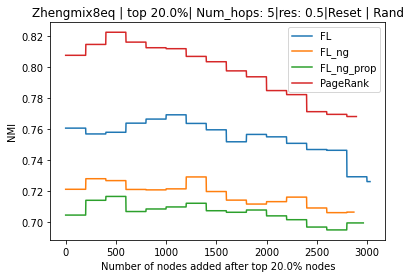

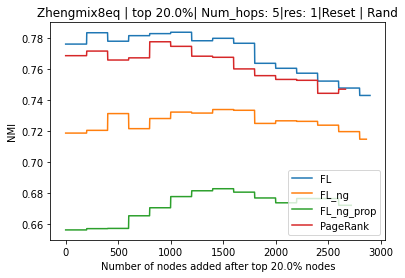

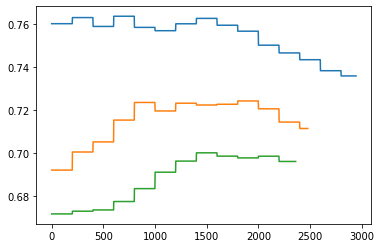

In [37]:
#Chandra's version. 
import community as community_louvain

import analysis as an
#import Cust_Final as RC10
import networkx.algorithms.community.louvain as Louv
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from collections import deque
from matplotlib.backends.backend_pdf import PdfPages

res_=[] #0.26, 0.24 is best for Louvain, 3.3, 2.0
labels=[]
total_labels=[]
names = []

#data_names = ['Zhengmix8eq','mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']

#data_names = ['miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']


data_names = ['Zhengmix8eq']


# FR_ord = ['Rd', 'Ord']
# FR_Recalc = ['FR_avg', 'FR_Re']
FR_tp = ['FL','FL_ng','FL_ng_prop','PageRank']
Num_hops = {0:'5',1:'log(n)'}
Mod_tp = {0: 'Louv'}

#top k% nodes for induced subgraph
k=0.2
reset_or_static = 0
rand_or_FR_order = 0 
traverse = {0:'Reset',1:'Static'}
ord = {0:'Rand',1:'FR_order'}

#list of plotted figures
figures = []

for data in data_names: 
    #pdf_name = './Plots/'+data+'(k =' + str(k*100) + '%).pdf'
    pdf_name = './Plots/'+data+'.pdf'
    for survive in [0]:
        '''
        Get the Graph from Edge_List and get the labels
        '''
        #DO not recalculate Graph for non bulk RNA datasets
        if data not in ['mRNA','miRNA'] and survive==1:
            continue
        G, label= data_to_graph(data,survive)
        print('Number of nodes:',G.number_of_nodes())
        #get unique entry in label
        # with open('./Results/'+data+'.txt', 'a') as f:
        #     f.write('True Labels: [')
        #     for i in list(set(label)):
        #         f.write(str(i)+', ')
        #     f.write('] # of Comms: ' + str(len(list(set(label))))+ '\n')

        for Num_hop in [0]:
            for res in [0.5,1,2]:
                
                partition = Louv.louvain_partitions(G, resolution= res)
                partition_ = deque(partition, maxlen=1).pop()
                new_label=get_labels(partition_,len(G.nodes()))


                ps_o=met.purity_score(label,new_label)
                nmi_o=normalized_mutual_info_score(label,new_label)
                print("Original NMI and purity is ",nmi_o,ps_o)


                for Mod_type in [0]:
                    plt.figure()
                    for FR_type in range(4):
                        #skip survive for non bulk RNA datasets
                        if data not in ['mRNA','miRNA'] and survive==1:
                            continue
                        #Do pagerank once only (No different hops for PageRank)
                        #if FR_type==3 and Num_hop==1:
                        #    continue

                        name =  data + ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops'
                        if FR_type==3:
                            name = data + ' (top ' + str(k*100) + '%): PageRank'
                        if data in ['mRNA','miRNA']:
                            name = data +  ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops' + ' + Survive: '+str(survive)
                            if FR_type==3:
                                name = data + ' (top ' + str(k*100) + '%): PageRank' + ' + Survive: '+str(survive)
                        print(name)
                        
                        
                        '''
                        Get induced subgraph of top k% nodes in FR value
                        '''
                        #Get induced subgraph
                        if Num_hop==0:
                            node2FR = calc_FlowRank(G, FR_type, 5)
                        else:
                            node2FR = calc_FlowRank(G, FR_type, np.log2(G.number_of_nodes()))
                        H, node_ordered_by_FR = getInducedSubgraph(G, k, node2FR)
                        #print('Number of nodes in subgraph:',H.number_of_nodes())


                        partition = Louv.louvain_partitions(H, resolution= res)
                        partition_ = deque(partition, maxlen=1).pop()
                        H_label = part_to_full_label(partition_,G.number_of_nodes())        
                        print("We are here", FR_tp[FR_type],Counter(H_label))



                        degs=dict(H.in_degree())
                        degs=list(degs.values())

                        bucket=np.zeros((max(degs)+1))
                        for ell in degs:
                            bucket[ell]=bucket[ell]+1
                
                        print(bucket)



                        print("For out degree")               
                        degs=dict(H.out_degree())
                        degs=list(degs.values())

                        bucket=np.zeros((max(degs)+1))
                        for ell in degs:
                            bucket[ell]=bucket[ell]+1
                        
                        print(bucket)




                        print("ch,ch", FR_tp[FR_type], len(H.edges()))

                        '''
                        Calculate NMI and Purity for different resolutions
                        '''
                        max_nmi = (0,0,0,0,[]) # (nmi, purity, res, FR_type, partition)
                        max_purity = (0,0,0,0,[])
                        
                        #partition = RC10.louvain_partitions(H, seed=0,resolution=res,FR_order=FR_order, FR_Recalc=FR_Rec, FR_type=FR_type, Mod_type=Mod_type)
                        partition = Louv.louvain_partitions(H, seed=0,resolution=res)
                        #partition = Louv.louvain_partitions(H,resolution=res)

                        partition_ = deque(partition, maxlen=1).pop()

                        nmi_ = get_NMI(H,partition_,label, G.number_of_nodes())
                        purity_ = get_Purity(H,partition_,label, G.number_of_nodes())
                        #print('NMI:', nmi_,'res:',res)
                        if nmi_>max_nmi[0]:
                            max_nmi = (nmi_,purity_,res,FR_type,partition_)
                        if purity_>max_purity[1]:
                            max_purity = (nmi_,purity_,res,FR_type,partition_)
                        '''
                        Write the results to Results folder
                        '''
                        #write_out(data, name, max_nmi, max_purity)
                        #print(' Max NMI = [' , round(max_nmi[0],3), ',', round(max_nmi[1],3), ']', ' res:= ', round(max_nmi[2],3))
                        '''
                        Add nodes to the subgraph by strong majority vote
                        '''
                        #See the trend by adding node to the subgraph by strong majority vote (in order of FlowRank Value)
                        H_label = part_to_full_label(max_nmi[4],G.number_of_nodes())
                        #print('H_label: ',H_label, 'len: ',len(H_label))
                        

                        NMI_List = []
                        NMI_List.append(max_nmi[0])

                        NMI_List = merge_by_vote(reset_or_static, rand_or_FR_order, node_ordered_by_FR, NMI_List,H_label)
                        
                                   
                        print("NMI_list:", NMI_List)
                        plt.plot(NMI_List, label = str(FR_tp[FR_type]))
                    
                        print('Number of nodes not included: ' , G.number_of_nodes() - H.number_of_nodes() - len(NMI_List)+1) 
                        print('NMI after top ', k*100, '% nodes:', round(NMI_List[0],3))
                        print('Max NMI: ', round(max(NMI_List),3))
                    
                #Plot all at once
                plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                plt.ylabel('NMI')
                plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|'
                          +str(traverse[reset_or_static]) + ' | ' + str(ord[rand_or_FR_order]))
                plt.legend()
    
    p = PdfPages(pdf_name)            
    fig_nums = plt.get_fignums() 
    figs = [plt.figure(n) for n in fig_nums] 
	
    for picture in figs:
        plt.show(picture)


    #partition = Louv.louvain_partitions(G, seed=0,resolution=res)
 

	# # iterating over the numbers in list 
    # for fig in figs: 
	# 	# and saving the files 
    #     fig.savefig(p, format='pdf') 
	
	# # close the object 
    # p.close() 
    # plt.close('all')
    
        
            

                                
                    

                    



###  Top K subgraph testing

In [ ]:
import analysis as an
#import Cust_Final as RC10
import networkx.algorithms.community.louvain as Louv
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from collections import deque

res_=[] #0.26, 0.24 is best for Louvain, 3.3, 2.0
labels=[]
total_labels=[]
names = []

data_names = ['Zhengmix8eq','mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
# FR_ord = ['Rd', 'Ord']
# FR_Recalc = ['FR_avg', 'FR_Re']
FR_tp = ['FL','FL_ng','FL_ng_prop','PageRank']
Num_hops = ['5','log(n)']
Mod_tp = {0: 'Louv'}

#top k% nodes for induced subgraph
k=0.2
for data in data_names: 
    for survive in [0,1]:
        '''
        Get the Graph from Edge_List and get the labels
        '''
        #DO not recalculate Graph for non bulk RNA datasets
        if data not in ['mRNA','miRNA'] and survive==1:
            continue
        G, label= data_to_graph(data,survive)
        print('Number of nodes:',G.number_of_nodes())
        #get unique entry in label
        with open('./Results/'+data+'.txt', 'a') as f:
            f.write('True Labels: [')
            for i in list(set(label)):
                f.write(str(i)+', ')
            f.write('] # of Comms: ' + str(len(list(set(label))))+ '\n')

        for Num_hop in [0,1]:
            for FR_type in range(4):
                for Mod_type in [0]:
                    #skip survive for non bulk RNA datasets
                    if data not in ['mRNA','miRNA'] and survive==1:
                        continue
                    #Do pagerank once only (No different hops for PageRank)
                    if FR_type==3 and Num_hop==0:
                        continue

                    name =  data + ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops'
                    if FR_type==3:
                        name = data + ' (top ' + str(k*100) + '%): PageRank'
                    if data in ['mRNA','miRNA']:
                        name = data +  ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops' + ' + Survive: '+str(survive)
                        if FR_type==3:
                            name = data + ' (top ' + str(k*100) + '%): PageRank' + ' + Survive: '+str(survive)
                    #print(name)
                    
                    
                    '''
                    Get induced subgraph of top k% nodes in FR value
                    '''
                    #Get induced subgraph
                    if Num_hop==0:
                        node2FR = calc_FlowRank(G, FR_type, 5)
                    else:
                        node2FR = calc_FlowRank(G, FR_type, np.log2(G.number_of_nodes()))
                    H = getInducedSubgraph(G, k, node2FR)
                    #print('Number of nodes in subgraph:',H.number_of_nodes())

                    '''
                    Calculate NMI and Purity for different resolutions
                    '''
                    max_nmi = (0,0,0,0,[]) # (nmi, purity, res, FR_type, partition)
                    max_purity = (0,0,0,0,[])
                    res_list = []
                    for i in range(40):
                        res_list.append(i/20+0.01)
                    
                    for res in res_list:
                        #partition = RC10.louvain_partitions(H, seed=0,resolution=res,FR_order=FR_order, FR_Recalc=FR_Rec, FR_type=FR_type, Mod_type=Mod_type)
                        partition = Louv.louvain_partitions(H, seed=0,resolution=res)

                        partition_ = deque(partition, maxlen=1).pop()

                        nmi_ = get_NMI(H,partition_,label, G.number_of_nodes())
                        purity_ = get_Purity(H,partition_,label, G.number_of_nodes())
                        #print('NMI:', nmi_,'res:',res)
                        if nmi_>max_nmi[0]:
                            max_nmi = (nmi_,purity_,res,FR_type,partition_)
                        if purity_>max_purity[1]:
                            max_purity = (nmi_,purity_,res,FR_type,partition_)
                    '''
                    Write the results to Results folder
                    '''
                    write_out(data, name, max_nmi, max_purity)
                    #print(' Max NMI = [' , round(max_nmi[0],3), ',', round(max_nmi[1],3), ']', ' res:= ', round(max_nmi[2],3))
                    #print('Partition sizes:',end=' ')
                    # for i in max_nmi[4]:
                    #     print(len(i),end=' ')
                    # print()  
                    # 
                    #  #print(' Max Purity = [' , round(max_purity[0],3), ',', round(max_purity[1],3), ']', ' res:= ', round(max_purity[2],3))
                    # #print('Partition sizes:',end=' ')
                    # for i in max_purity[4]:
                    #    print(len(i),end=' ')
                    # print()  



### Top k% induced subgraph + Strong Majority Vote later

#### Strong Majority vote function

In [7]:
from collections import Counter, defaultdict
import random
def vote(G, H_label, node):
    #check every outgoing edge of node and counter the majority vote
    vt = defaultdict(int)
    for i in G.out_edges(node):
        #print('i:',i)
        vt[H_label[i[1]]] += 1
    #get the most common label
    most_common_label, most_common_count = Counter(vt).most_common(1)[0]
    
    #Strong Majority Vote
    if most_common_count < len(G.out_edges(node))/2:
        return -1
    else:
        return most_common_label
    
def merge_by_vote(reset_or_static, rand_or_FR_order, node_ordered_by_FR, NMI_List, H_label, G, label, Purity_List):
    flag = 1
    cnt = 0
    n = len(node_ordered_by_FR)
    
    if rand_or_FR_order==0: #0 = random order
        random.shuffle(node_ordered_by_FR)                    
    while(flag):
        flag = 0
        #Reset Traversal (If found a node to merge, start the loop over)
        if reset_or_static==0: #0 = reset
            for node in node_ordered_by_FR:
                #Already has a community assigned (Skip)
                if H_label[node] != -1:
                    continue
                new_comm = vote(G, H_label, node)
                if new_comm != -1:
                    H_label[node] = new_comm
                    flag=1
                    cnt +=1
                    #Calculate new NMI every 5% of nodes
                    if cnt > n/20:
                        new_nmi = get_NMI2(H_label, label)
                        new_purity = get_Purity2(H_label, label)
                        #print('NMI:',new_nmi)
                        NMI_List.append(new_nmi)
                        Purity_List.append(new_purity)
                        cnt = 0
                    else:
                        NMI_List.append(NMI_List[-1])
                        Purity_List.append(Purity_List[-1])

                    break
        #Static Change (Update all nodes at once every loop) 
        else: #1 = static
            H_label_new = H_label.copy()
            for node in node_ordered_by_FR:
                #Already has a community assigned (Skip)
                if H_label[node] != -1:
                    continue
                new_comm = vote(G, H_label, node)
                if new_comm != -1:
                    H_label_new[node] = new_comm
                    flag=1
                    cnt +=1
                    if cnt > n/20:
                        new_nmi = get_NMI2(H_label_new, label)
                        new_purity = get_Purity2(H_label_new, label)
                        #print('NMI:',new_nmi)
                        NMI_List.append(new_nmi)
                        Purity_List.append(new_purity)
                        cnt = 0
                    else:
                        NMI_List.append(NMI_List[-1])
                        Purity_List.append(Purity_List[-1])
            H_label = H_label_new
    NMI_List[-1] = get_NMI2(H_label, label)
    Purity_List[-1] = get_Purity2(H_label, label)
    return NMI_List, Purity_List

#### Top k + Strong Majority 

##### Working Most basic code

In [ ]:
import analysis as an
#import Cust_Final as RC10
import networkx.algorithms.community.louvain as Louv
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from collections import deque
from matplotlib.backends.backend_pdf import PdfPages

res_=[] #0.26, 0.24 is best for Louvain, 3.3, 2.0
labels=[]
total_labels=[]
names = []

#data_names = ['Zhengmix8eq','mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
data_names = ['Zhengmix8eq']
# FR_ord = ['Rd', 'Ord']
# FR_Recalc = ['FR_avg', 'FR_Re']
FR_tp = ['FL','FL_ng','FL_ng_prop','PageRank']
Num_hops = ['5','log(n)']
Mod_tp = {0: 'Louv'}

#top k% nodes for induced subgraph
k=0.2


for data in data_names: 
    for survive in [0,1]:
        '''
        Get the Graph from Edge_List and get the labels
        '''
        #DO not recalculate Graph for non bulk RNA datasets
        if data not in ['mRNA','miRNA'] and survive==1:
            continue
        G, label= data_to_graph(data,survive)
        print('Number of nodes:',G.number_of_nodes())
        #get unique entry in label
        # with open('./Results/'+data+'.txt', 'a') as f:
        #     f.write('True Labels: [')
        #     for i in list(set(label)):
        #         f.write(str(i)+', ')
        #     f.write('] # of Comms: ' + str(len(list(set(label))))+ '\n')

        for Num_hop in [0]:
            for FR_type in range(4):
                for Mod_type in [0]:
                    #skip survive for non bulk RNA datasets
                    if data not in ['mRNA','miRNA'] and survive==1:
                        continue
                    #Do pagerank once only (No different hops for PageRank)
                    if FR_type==3 and Num_hop==1:
                        continue

                    name =  data + ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops'
                    if FR_type==3:
                        name = data + ' (top ' + str(k*100) + '%): PageRank'
                    if data in ['mRNA','miRNA']:
                        name = data +  ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops' + ' + Survive: '+str(survive)
                        if FR_type==3:
                            name = data + ' (top ' + str(k*100) + '%): PageRank' + ' + Survive: '+str(survive)
                    print(name)
                    
                    
                    '''
                    Get induced subgraph of top k% nodes in FR value
                    '''
                    #Get induced subgraph
                    if Num_hop==0:
                        node2FR = calc_FlowRank(G, FR_type, 5)
                    else:
                        node2FR = calc_FlowRank(G, FR_type, np.log2(G.number_of_nodes()))
                    H, node_ordered_by_FR = getInducedSubgraph(G, k, node2FR)
                    #print('Number of nodes in subgraph:',H.number_of_nodes())

                    '''
                    Calculate NMI and Purity for different resolutions
                    '''
                    max_nmi = (0,0,0,0,[]) # (nmi, purity, res, FR_type, partition)
                    max_purity = (0,0,0,0,[])
                    res_list = []
                    for i in range(10):
                        res_list.append(i/10+0.01)
                    
                    for res in res_list:
                        #partition = RC10.louvain_partitions(H, seed=0,resolution=res,FR_order=FR_order, FR_Recalc=FR_Rec, FR_type=FR_type, Mod_type=Mod_type)
                        partition = Louv.louvain_partitions(H, seed=0,resolution=res)
                        #partition = Louv.louvain_partitions(H,resolution=res)

                        partition_ = deque(partition, maxlen=1).pop()

                        nmi_ = get_NMI(H,partition_,label, G.number_of_nodes())
                        purity_ = get_Purity(H,partition_,label, G.number_of_nodes())
                        #print('NMI:', nmi_,'res:',res)
                        if nmi_>max_nmi[0]:
                            max_nmi = (nmi_,purity_,res,FR_type,partition_)
                        if purity_>max_purity[1]:
                            max_purity = (nmi_,purity_,res,FR_type,partition_)
                    '''
                    Write the results to Results folder
                    '''
                    #write_out(data, name, max_nmi, max_purity)
                    #print(' Max NMI = [' , round(max_nmi[0],3), ',', round(max_nmi[1],3), ']', ' res:= ', round(max_nmi[2],3))
                    '''
                    Add nodes to the subgraph by strong majority vote
                    '''
                    #See the trend by adding node to the subgraph by strong majority vote (in order of FlowRank Value)
                    H_label = part_to_full_label(max_nmi[4],G.number_of_nodes())
                    #print('H_label: ',H_label, 'len: ',len(H_label))
                    

                    NMI_List = []
                    NMI_List.append(max_nmi[0])

                    flag = 1

                    #node in the order of FR value

                    while(flag):
                        flag = 0
                        for node in node_ordered_by_FR:
                            #Already has a community assigned (Skip)
                            if H_label[node] != -1:
                                continue
                            new_comm = vote(G, H_label, node)
                            if new_comm != -1:
                                H_label[node] = new_comm
                                flag=1
                                #Calculate new NMI
                                new_nmi = get_NMI2(H_label, label)
                                #print('NMI:',new_nmi)
                                NMI_List.append(new_nmi)
                                break
                    #Plot NMI_List
                    #plot on the same graph
                    #x = [i for i in range(G.number_of_nodes() - H.number_of_nodes())]
                    plt.plot(NMI_List, label = str(FR_tp[FR_type]))
                    
                    # plt.title('NMI vs Number of nodes added ' + '| FR_type: ' + str(FR_tp[FR_type]) + ' ' + '| Data: ' + data)
                    # plt.show()
                    # #+1 because the first entry is the initial NMI
                    print('Number of nodes not included: ' , G.number_of_nodes() - H.number_of_nodes() - len(NMI_List)+1) 
                    print('NMI after top ', k*100, '% nodes:', round(NMI_List[0],3))
                    print('Max NMI: ', round(max(NMI_List),3))
        #Plot all at once
        plt.xlabel('Number of nodes added')
        plt.ylabel('NMI')
        plt.title('NMI vs Node added ' + '| Data: ' + data + ' | top ' + str(k*100) + '% subgraph')
        plt.legend()
        plt.show()     
                                
                    

                    
                    



In [ ]:
import matplotlib 
from matplotlib import pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages 

# customizing runtime configuration stored 
# in matplotlib.rcParams 
plt.rcParams["figure.figsize"] = [7.00, 3.50] 
plt.rcParams["figure.autolayout"] = True

plt.figure() 
plt.plot([17, 45, 7, 8, 7], color='orange') 

plt.figure() 
plt.plot([13, 25, 1, 6, 3], color='blue') 

plt.figure() 
plt.plot([22, 11, 2, 1, 23], color='green') 


def save_image(filename): 
	
	# PdfPages is a wrapper around pdf 
	# file so there is no clash and create 
	# files with no error. 
	p = PdfPages(filename) 
	
	# get_fignums Return list of existing 
	# figure numbers 
	fig_nums = plt.get_fignums() 
	figs = [plt.figure(n) for n in fig_nums] 
	
	# iterating over the numbers in list 
	for fig in figs: 
		
		# and saving the files 
		fig.savefig(p, format='pdf') 
	
	# close the object 
	p.close() 

# name your Pdf file 
filename = "multi_plot_image.pdf"

# call the function 
save_image(filename) 


##### PDF Export version (Final Working Version)

In [13]:
import analysis as an
import Cust_Top as RC10
import networkx.algorithms.community.louvain as Louv
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from collections import deque
from matplotlib.backends.backend_pdf import PdfPages
import os

res_=[] #0.26, 0.24 is best for Louvain, 3.3, 2.0
labels=[]
total_labels=[]
names = []

#data_names = ['Zhengmix8eq','mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
#data_names = ['miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
data_names = ['Citeseer','Eu core']
#data_names= ['biorxiv', 'Cora full']
#data_names = ['Zhengmix8eq']
# FR_ord = ['Rd', 'Ord']
# FR_Recalc = ['FR_avg', 'FR_Re']
FR_tp = ['FL','FL_ng','FL_ng_prop','PageRank']
Num_hops = {0:'5',1:'log(n)'}
Mod_tp = {0: 'Louv'}

#top k% nodes for induced subgraph
k=0.2
traverse = {0:'Reset',1:'Static'}
ord = {0:'Rand',1:'FR_order'}

#list of plotted figures
figures = []

for data in data_names: 
    #pdf_name = './Plots/'+data+'(k =' + str(k*100) + '%).pdf'
    pdf_name = './Plots/'+data+'/'+data+'.pdf'
    
    for survive in [0]:
        '''
        Get the Graph from Edge_List and get the labels
        '''
        #DO not recalculate Graph for non bulk RNA datasets
        if data not in ['mRNA','miRNA'] and survive==1:
            continue
        G, label= data_to_graph(data,survive)
        #add self loop to nodes without outgoing edges
        for node in G.nodes():
            if not list(G.successors(node)):
                G.add_edge(node, node, weight=1)
        print('Number of nodes:',G.number_of_nodes())
        #get unique entry in label
        # with open('./Results/'+data+'.txt', 'a') as f:
        #     f.write('True Labels: [')
        #     for i in list(set(label)):
        #         f.write(str(i)+', ')
        #     f.write('] # of Comms: ' + str(len(list(set(label))))+ '\n')
        for trav in [0]:
            for node_ord in [1]:
                for Num_hop in [0]:
                    for res in [0.5,1,2]:
                        for Mod_type in [0]:
                            plt.figure() # figure for NMI
                            plt.figure() # figure for purity
                            for FR_type in range(4):
                                #skip survive for non bulk RNA datasets
                                if data not in ['mRNA','miRNA'] and survive==1:
                                    continue
                                #Do pagerank once only (No different hops for PageRank)
                                #if FR_type==3 and Num_hop==1:
                                #    continue

                                name =  data + ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops'
                                if FR_type==3:
                                    name = data + ' (top ' + str(k*100) + '%): PageRank'
                                if data in ['mRNA','miRNA']:
                                    name = data +  ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops' + ' + Survive: '+str(survive)
                                    if FR_type==3:
                                        name = data + ' (top ' + str(k*100) + '%): PageRank' + ' + Survive: '+str(survive)
                                print(name)
                                data_directory = f'./Plots/{data}'
                                file_path = f'{data_directory}/{data}.txt'
                                # Create the directory if it doesn't exist
                                os.makedirs(data_directory, exist_ok=True)
                                with open(file_path, 'a') as f:
                                    f.write(name+'\n')
                                
                                '''
                                Get induced subgraph of top k% nodes in FR value
                                '''
                                #Get induced subgraph
                                if Num_hop==0:
                                    node2FR = calc_FlowRank(G, FR_type, 5)
                                else:
                                    node2FR = calc_FlowRank(G, FR_type, np.log2(G.number_of_nodes()))
                                H, node_ordered_by_FR = getInducedSubgraph(G, k, node2FR)
                                #print('Number of nodes in subgraph:',H.number_of_nodes())

                                '''
                                Calculate NMI and Purity for different resolutions
                                '''
                                max_nmi = (0,0,0,0,[]) # (nmi, purity, res, FR_type, partition)
                                max_purity = (0,0,0,0,[])
                                
                                # partition = RC10.louvain_partitions(H, seed=0,resolution=res, FR_type=FR_type, Mod_type=Mod_type)
                                partition = Louv.louvain_partitions(H, seed=0,resolution=res )
                                #partition = Louv.louvain_partitions(H,resolution=res)

                                partition_ = deque(partition, maxlen=1).pop()

                                nmi_ = get_NMI(H,partition_,label, G.number_of_nodes())
                                purity_ = get_Purity(H,partition_,label, G.number_of_nodes())
                                #print('NMI:', nmi_,'res:',res)
                                if nmi_>max_nmi[0]:
                                    max_nmi = (nmi_,purity_,res,FR_type,partition_)
                                if purity_>max_purity[1]:
                                    max_purity = (nmi_,purity_,res,FR_type,partition_)
                                '''
                                Write the results to Results folder
                                '''
                                #write_out(data, name, max_nmi, max_purity)
                                #print(' Max NMI = [' , round(max_nmi[0],3), ',', round(max_nmi[1],3), ']', ' res:= ', round(max_nmi[2],3))
                                '''
                                Add nodes to the subgraph by strong majority vote
                                '''
                                #See the trend by adding node to the subgraph by strong majority vote (in order of FlowRank Value)
                                H_label = part_to_full_label(max_nmi[4],G.number_of_nodes())
                                #print('H_label: ',H_label, 'len: ',len(H_label))
                                

                                NMI_List = []
                                NMI_List.append(max_nmi[0])

                                Purity_List = []
                                Purity_List.append(max_purity[1])

                                NMI_List, Purity_List = merge_by_vote(trav, node_ord, node_ordered_by_FR, NMI_List, H_label, G, label, Purity_List)
                                
                                        
                                
                                
                                #Plot NMI_List
                                fig_numbers = plt.get_fignums()
                                nmi_fig =fig_numbers[-1]
                                purity_fig = fig_numbers[-2]

                                #plot NMI
                                plt.figure(nmi_fig)
                                plt.plot(NMI_List, label = str(FR_tp[FR_type]))
                                with open(file_path, 'a') as f:
                                    f.write('# of nodes not included: ' + str(G.number_of_nodes() - H.number_of_nodes() - len(NMI_List)+1) + '\n')
                                    f.write('NMI after top ' + str(k*100) + '% nodes: ' + str(round(NMI_List[0],3)) + '\n')
                                    f.write('Max NMI: ' + str(round(max(NMI_List),3)) + '\n')
                                print('Number of nodes not included: ' , G.number_of_nodes() - H.number_of_nodes() - len(NMI_List)+1) 
                                print('NMI after top ', k*100, '% nodes:', round(NMI_List[0],3))
                                print('Max NMI: ', round(max(NMI_List),3))

                                #plot Purity
                                plt.figure(purity_fig)
                                plt.plot(Purity_List, label = str(FR_tp[FR_type]))
                                with open(file_path, 'a') as f:
                                    f.write('Purity after top ' + str(k*100) + '% nodes: ' + str(round(Purity_List[0],3)) + '\n')
                                    f.write('Max Purity: ' + str(round(max(Purity_List),3)) + '\n')
                                
                        plt.figure(nmi_fig)    
                        #Plot all at once
                        plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                        plt.ylabel('NMI')
                        plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|'
                                +str(traverse[trav]) + ' | ' + str(ord[node_ord]))
                        plt.legend()

                        plt.figure(purity_fig)
                        #Plot all at once
                        plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                        plt.ylabel('Purity')
                        plt.title(data + ' | top ' + str(k*100) + '%' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|'
                                +str(traverse[trav]) + ' | ' + str(ord[node_ord]))
                        plt.legend()
    
    p = PdfPages(pdf_name)            
    fig_nums = plt.get_fignums() 
    figs = [plt.figure(n) for n in fig_nums] 
	
	# iterating over the numbers in list 
    for fig in figs: 
		# and saving the files 
        fig.savefig(p, format='pdf') 
	
	# close the object 
    p.close() 
    plt.close('all')
    
        
            

                                
                    

                    
                    



Validation for `citeseer_labels` and `citeseer_features` passes.
7 6
Number of nodes: 2120
Citeseer (top 20.0%): FL + 5 hops
Number of nodes not included:  728
NMI after top  20.0 % nodes: 0.457
Max NMI:  0.457
Citeseer (top 20.0%): FL_ng + 5 hops


i:\내 드라이브\backup\document\USC\Research\MCPC\Code\Codes\FlowRank_General.py:424: RuntimeWarning: invalid value encountered in scalar divide
  rank[v]=v_cover[v]/sc


Number of nodes not included:  1595
NMI after top  20.0 % nodes: 0.424
Max NMI:  0.424
Citeseer (top 20.0%): FL_ng_prop + 5 hops


i:\내 드라이브\backup\document\USC\Research\MCPC\Code\Codes\FlowRank_General.py:424: RuntimeWarning: invalid value encountered in scalar divide
  rank[v]=v_cover[v]/sc


Number of nodes not included:  1597
NMI after top  20.0 % nodes: 0.424
Max NMI:  0.424
Citeseer (top 20.0%): PageRank
Number of nodes not included:  502
NMI after top  20.0 % nodes: 0.453
Max NMI:  0.453
Citeseer (top 20.0%): FL + 5 hops
Number of nodes not included:  873
NMI after top  20.0 % nodes: 0.457
Max NMI:  0.457
Citeseer (top 20.0%): FL_ng + 5 hops


i:\내 드라이브\backup\document\USC\Research\MCPC\Code\Codes\FlowRank_General.py:424: RuntimeWarning: invalid value encountered in scalar divide
  rank[v]=v_cover[v]/sc


Number of nodes not included:  1595
NMI after top  20.0 % nodes: 0.409
Max NMI:  0.409
Citeseer (top 20.0%): FL_ng_prop + 5 hops


i:\내 드라이브\backup\document\USC\Research\MCPC\Code\Codes\FlowRank_General.py:424: RuntimeWarning: invalid value encountered in scalar divide
  rank[v]=v_cover[v]/sc


Number of nodes not included:  1597
NMI after top  20.0 % nodes: 0.409
Max NMI:  0.409
Citeseer (top 20.0%): PageRank
Number of nodes not included:  502
NMI after top  20.0 % nodes: 0.453
Max NMI:  0.453
Citeseer (top 20.0%): FL + 5 hops
Number of nodes not included:  883
NMI after top  20.0 % nodes: 0.454
Max NMI:  0.454
Citeseer (top 20.0%): FL_ng + 5 hops


i:\내 드라이브\backup\document\USC\Research\MCPC\Code\Codes\FlowRank_General.py:424: RuntimeWarning: invalid value encountered in scalar divide
  rank[v]=v_cover[v]/sc


Number of nodes not included:  1595
NMI after top  20.0 % nodes: 0.403
Max NMI:  0.403
Citeseer (top 20.0%): FL_ng_prop + 5 hops


i:\내 드라이브\backup\document\USC\Research\MCPC\Code\Codes\FlowRank_General.py:424: RuntimeWarning: invalid value encountered in scalar divide
  rank[v]=v_cover[v]/sc


Number of nodes not included:  1597
NMI after top  20.0 % nodes: 0.408
Max NMI:  0.408
Citeseer (top 20.0%): PageRank
Number of nodes not included:  502
NMI after top  20.0 % nodes: 0.453
Max NMI:  0.453
42 41
Number of nodes: 1005
Eu core (top 20.0%): FL + 5 hops
Number of nodes not included:  789
NMI after top  20.0 % nodes: 0.632
Max NMI:  0.632
Eu core (top 20.0%): FL_ng + 5 hops
Number of nodes not included:  793
NMI after top  20.0 % nodes: 0.655
Max NMI:  0.655
Eu core (top 20.0%): FL_ng_prop + 5 hops
Number of nodes not included:  798
NMI after top  20.0 % nodes: 0.667
Max NMI:  0.667
Eu core (top 20.0%): PageRank
Number of nodes not included:  127
NMI after top  20.0 % nodes: 0.166
Max NMI:  0.166
Eu core (top 20.0%): FL + 5 hops
Number of nodes not included:  794
NMI after top  20.0 % nodes: 0.649
Max NMI:  0.649
Eu core (top 20.0%): FL_ng + 5 hops
Number of nodes not included:  795
NMI after top  20.0 % nodes: 0.679
Max NMI:  0.679
Eu core (top 20.0%): FL_ng_prop + 5 hops
Nu

: 

##### PDF Export Parallel Computation Version

In [ ]:
import analysis as an
#import Cust_Final as RC10
import networkx.algorithms.community.louvain as Louv
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from collections import deque
from matplotlib.backends.backend_pdf import PdfPages
import concurrent.futures

res_=[] #0.26, 0.24 is best for Louvain, 3.3, 2.0
labels=[]
total_labels=[]
names = []

#data_names = ['Zhengmix8eq','mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
data_names = ['miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']

#data_names = ['Zhengmix8eq']
# FR_ord = ['Rd', 'Ord']
# FR_Recalc = ['FR_avg', 'FR_Re']
FR_tp = ['FL','FL_ng','FL_ng_prop','PageRank']
Num_hops = {0:'5',1:'log(n)'}
Mod_tp = {0: 'Louv'}

#top k% nodes for induced subgraph
k=0.2

#list of plotted figures
figures = []

def calc_in_parallel(data):
    #pdf_name = './Plots/'+data+'(k =' + str(k*100) + '%).pdf'
    pdf_name = './Plots/'+data+'.pdf'
    for survive in [0]:
        '''
        Get the Graph from Edge_List and get the labels
        '''
        #DO not recalculate Graph for non bulk RNA datasets
        if data not in ['mRNA','miRNA'] and survive==1:
            continue
        G, label= data_to_graph(data,survive)
        print('Number of nodes:',G.number_of_nodes())
        #get unique entry in label
        # with open('./Results/'+data+'.txt', 'a') as f:
        #     f.write('True Labels: [')
        #     for i in list(set(label)):
        #         f.write(str(i)+', ')
        #     f.write('] # of Comms: ' + str(len(list(set(label))))+ '\n')

        for Num_hop in [0]:
            for res in [0.5,1,2]:
                for Mod_type in [0]:
                    plt.figure()
                    for FR_type in range(4):
                        #skip survive for non bulk RNA datasets
                        if data not in ['mRNA','miRNA'] and survive==1:
                            continue
                        #Do pagerank once only (No different hops for PageRank)
                        #if FR_type==3 and Num_hop==1:
                        #    continue

                        name =  data + ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops'
                        if FR_type==3:
                            name = data + ' (top ' + str(k*100) + '%): PageRank'
                        if data in ['mRNA','miRNA']:
                            name = data +  ' (top ' + str(k*100) + '%): '+ str(FR_tp[FR_type]) + ' + '+ str(Num_hops[Num_hop]) +' hops' + ' + Survive: '+str(survive)
                            if FR_type==3:
                                name = data + ' (top ' + str(k*100) + '%): PageRank' + ' + Survive: '+str(survive)
                        print(name)
                        
                        
                        '''
                        Get induced subgraph of top k% nodes in FR value
                        '''
                        #Get induced subgraph
                        if Num_hop==0:
                            node2FR = calc_FlowRank(G, FR_type, 5)
                        else:
                            node2FR = calc_FlowRank(G, FR_type, np.log2(G.number_of_nodes()))
                        H, node_ordered_by_FR = getInducedSubgraph(G, k, node2FR)
                        #print('Number of nodes in subgraph:',H.number_of_nodes())

                        '''
                        Calculate NMI and Purity for different resolutions
                        '''
                        max_nmi = (0,0,0,0,[]) # (nmi, purity, res, FR_type, partition)
                        max_purity = (0,0,0,0,[])
                        
                        #partition = RC10.louvain_partitions(H, seed=0,resolution=res,FR_order=FR_order, FR_Recalc=FR_Rec, FR_type=FR_type, Mod_type=Mod_type)
                        partition = Louv.louvain_partitions(H, seed=0,resolution=res)
                        #partition = Louv.louvain_partitions(H,resolution=res)

                        partition_ = deque(partition, maxlen=1).pop()

                        nmi_ = get_NMI(H,partition_,label, G.number_of_nodes())
                        purity_ = get_Purity(H,partition_,label, G.number_of_nodes())
                        #print('NMI:', nmi_,'res:',res)
                        if nmi_>max_nmi[0]:
                            max_nmi = (nmi_,purity_,res,FR_type,partition_)
                        if purity_>max_purity[1]:
                            max_purity = (nmi_,purity_,res,FR_type,partition_)
                        '''
                        Write the results to Results folder
                        '''
                        #write_out(data, name, max_nmi, max_purity)
                        #print(' Max NMI = [' , round(max_nmi[0],3), ',', round(max_nmi[1],3), ']', ' res:= ', round(max_nmi[2],3))
                        '''
                        Add nodes to the subgraph by strong majority vote
                        '''
                        #See the trend by adding node to the subgraph by strong majority vote (in order of FlowRank Value)
                        H_label = part_to_full_label(max_nmi[4],G.number_of_nodes())
                        #print('H_label: ',H_label, 'len: ',len(H_label))
                        

                        NMI_List = []
                        NMI_List.append(max_nmi[0])

                        flag = 1

                        #node in the order of FR value

                        while(flag):
                            flag = 0
                            for node in node_ordered_by_FR:
                                #Already has a community assigned (Skip)
                                if H_label[node] != -1:
                                    continue
                                new_comm = vote(G, H_label, node)
                                if new_comm != -1:
                                    H_label[node] = new_comm
                                    flag=1
                                    #Calculate new NMI
                                    new_nmi = get_NMI2(H_label, label)
                                    #print('NMI:',new_nmi)
                                    NMI_List.append(new_nmi)
                                    break
                        #Plot NMI_List
                        #plot on the same graph
                        #x = [i for i in range(G.number_of_nodes() - H.number_of_nodes())]
                        
                        plt.plot(NMI_List, label = str(FR_tp[FR_type]))
                        
                        # plt.title('NMI vs Number of nodes added ' + '| FR_type: ' + str(FR_tp[FR_type]) + ' ' + '| Data: ' + data)
                        # plt.show()
                        # #+1 because the first entry is the initial NMI
                        print('Number of nodes not included: ' , G.number_of_nodes() - H.number_of_nodes() - len(NMI_List)+1) 
                        print('NMI after top ', k*100, '% nodes:', round(NMI_List[0],3))
                        print('Max NMI: ', round(max(NMI_List),3))
                    
                #Plot all at once
                plt.xlabel('Number of nodes added after top ' + str(k*100) + '% nodes')
                plt.ylabel('NMI')
                plt.title('Data: ' + data + ' | top ' + str(k*100) + '% subgraph' + '| Num_hops: ' + str(Num_hops[Num_hop]) + '|res: ' + str(res)+ '|Reset Traversal')
                plt.legend()
    
    p = PdfPages(pdf_name)            
    fig_nums = plt.get_fignums() 
    figs = [plt.figure(n) for n in fig_nums] 
	
	# iterating over the numbers in list 
    for fig in figs: 
		# and saving the files 
        fig.savefig(p, format='pdf') 
	
	# close the object 
    p.close() 
    plt.close('all')
    
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(calc_in_parallel, data_names)
        
            

                                
                    

                    
                    



## Louv + Cust-Louv on All Datasets

### Codes

In [ ]:
from collections import defaultdict, deque

def get_labels(partition,n_s):
    #final_partition_1 = deque(partition, maxlen=1).pop()
    #print(final_partition_1)


    label_1=np.zeros((n_s))
    c=0
    for sets in partition:
        for ell in sets:
            label_1[ell]=c
        
        c=c+1

    return label_1

In [ ]:
import analysis as an
import Cust_Final as RC
#import networkx.algorithms.community.louvain as Louv
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from collections import deque

res_=[] #0.26, 0.24 is best for Louvain, 3.3, 2.0
labels=[]
total_labels=[]
names = []

#data_names = ['Zhengmix8eq','mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
data_names = ['miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
# FR_ord = ['Rd', 'Ord']
# FR_Recalc = ['FR_avg', 'FR_Re']
FR_ord = ['Rd', 'Ord']
FR_Recalc = ['FR_avg', 'FR_Re']
FR_tp = ['FL','FL_ng','FL_ng_prop','PageRank']
Mod_tp = {0:'Louv', 2:'Cust2', 6:'Cust6', 11:'Cust11'}


for data in data_names: 
    for survive in [0]:
    #for survive in [0,1]:
        '''
        Get the Graph from Edge_List and get the labels
        '''
        #DO not recalculate Graph for non bulk RNA datasets
        if data not in ['mRNA','miRNA'] and survive==1:
            continue
        G, label= data_to_graph(data,survive)
        print('Number of nodes:',G.number_of_nodes())
        #get unique entry in label
        with open('./Results/'+data+'.txt', 'a') as f:
            f.write('True Labels: [')
            for i in list(set(label)):
                f.write(str(i)+', ')
            f.write('] # of Comms: ' + str(len(list(set(label))))+ '\n')

        
        for FR_type in range(4):
            for FR_order in [0]:
                for FR_Rec in [0]:
                    for Mod_type in [0,2,6,11]:
                        #skip survive for non bulk RNA datasets
                        if data not in ['mRNA','miRNA'] and survive==1:
                            continue
                        
                        name =  data + '(All nodes): '+ str(FR_tp[FR_type]) + ' + '+ str(Mod_tp[Mod_type])
                        if FR_type==3:
                            name = data + ' (All nodes): PageRank' + ' + '+ str(Mod_tp[Mod_type])
                        if data in ['mRNA','miRNA']:
                            name = data + ' (All nodes): '+ str(FR_tp[FR_type]) + ' + '+ str(Mod_tp[Mod_type]) + ' + Survive: '+str(survive)
                            if FR_type==3:
                                name = data + ' (All nodes): PageRank' + ' + '+ str(Mod_tp[Mod_type]) + ' + Survive: '+str(survive)
                        #print(name)
                        
                        #Louvain doesn't have FlowRank values involved
                        if Mod_type==0:
                            name = data + ' (All nodes): '+ str(Mod_tp[Mod_type])
                        #Louvain just runs once
                        if Mod_type==0:
                            if FR_type!=0:
                                continue
                        #print('Number of nodes in subgraph:',H.number_of_nodes())

                        '''
                        Calculate NMI and Purity for different resolutions
                        '''
                        max_nmi = (0,0,0,0,[]) # (nmi, purity, res, FR_type, partition)
                        max_purity = (0,0,0,0,[])
                        res_list = []
                        for i in range(20):
                            res_list.append(i/10+0.01)
                        
                        for res in res_list:
                            partition = RC.louvain_partitions(G, seed=0,resolution=res,FR_order=FR_order, FR_Recalc=FR_Rec, FR_type=FR_type, Mod_type=Mod_type)
                            
                            partition_ = deque(partition, maxlen=1).pop()
                            label_new = get_labels(partition_,G.number_of_nodes())

                            nmi_ = NMI(label,label_new)
                            purity_ = met.purity_score(label,label_new)
                            #print('NMI:', nmi_,'res:',res)
                            if nmi_>max_nmi[0]:
                                max_nmi = (nmi_,purity_,res,FR_type,partition_)
                            if purity_>max_purity[1]:
                                max_purity = (nmi_,purity_,res,FR_type,partition_)
                        '''
                        Write the results to Results folder
                        '''
                        print ('Max NMI: ',max_nmi[0], 'at res: ',max_nmi[2])
                        write_out(data, name, max_nmi, max_purity)
                        #print(' Max NMI = [' , round(max_nmi[0],3), ',', round(max_nmi[1],3), ']', ' res:= ', round(max_nmi[2],3))
                        #print('Partition sizes:',end=' ')
                        # for i in max_nmi[4]:
                        #     print(len(i),end=' ')
                        # print()  
                        # 
                        #  #print(' Max Purity = [' , round(max_purity[0],3), ',', round(max_purity[1],3), ']', ' res:= ', round(max_purity[2],3))
                        # #print('Partition sizes:',end=' ')
                        # for i in max_purity[4]:
                        #    print(len(i),end=' ')
                        # print()  



### Debugging

In [ ]:
import analysis as an
import Cust_Final as RC
#import networkx.algorithms.community.louvain as Louv
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from collections import deque

res_=[] #0.26, 0.24 is best for Louvain, 3.3, 2.0
labels=[]
total_labels=[]
names = []

#data_names = ['Zhengmix8eq','mRNA','miRNA','FashionMNIST','MNIST','seeds','breast-cancer','Omniglot','bbc_news','20NewsGroups_tfdif','biorxiv','big_patent','Cora','Cora full','Citeseer','Eu core']
data_names = ['20NewsGroups_tfdif', 'Omniglot', 'Cora full']
#data_names = ['Omniglot']
# FR_ord = ['Rd', 'Ord']
# FR_Recalc = ['FR_avg', 'FR_Re']
FR_ord = ['Rd', 'Ord']
FR_Recalc = ['FR_avg', 'FR_Re']
FR_tp = ['FL','FL_ng','FL_ng_prop','PageRank']
Mod_tp = {0:'Louv', 2:'Cust2', 6:'Cust6', 11:'Cust11'}


for data in data_names: 
    with open('./Results/'+data+'.txt', 'a') as f:
        f.write('__________________________________________________________________________________________\n')
    for survive in [0]:
    #for survive in [0,1]:
        '''
        Get the Graph from Edge_List and get the labels
        '''
        #DO not recalculate Graph for non bulk RNA datasets
        if data not in ['mRNA','miRNA'] and survive==1:
            continue
        G, label= data_to_graph(data,survive)
        print('Number of nodes:',G.number_of_nodes())
        #get unique entry in label
        with open('./Results/'+data+'.txt', 'a') as f:
            f.write('True Labels: [')
            for i in list(set(label)):
                f.write(str(i)+', ')
            f.write('] # of Comms: ' + str(len(list(set(label))))+ '\n')

        
        for FR_type in range(4):
            for FR_order in [0]:
                for FR_Rec in [0]:
                    for Mod_type in [0,2,6,11]:
                    #for Mod_type in [0]:
                        #skip survive for non bulk RNA datasets
                        if data not in ['mRNA','miRNA'] and survive==1:
                            continue
                        
                        name =  data + '(All nodes): '+ str(FR_tp[FR_type]) + ' + '+ str(Mod_tp[Mod_type])
                        if FR_type==3:
                            name = data + ' (All nodes): PageRank' + ' + '+ str(Mod_tp[Mod_type])
                        if data in ['mRNA','miRNA']:
                            name = data + ' (All nodes): '+ str(FR_tp[FR_type]) + ' + '+ str(Mod_tp[Mod_type]) + ' + Survive: '+str(survive)
                            if FR_type==3:
                                name = data + ' (All nodes): PageRank' + ' + '+ str(Mod_tp[Mod_type]) + ' + Survive: '+str(survive)
                        
                        
                        #Louvain doesn't have FlowRank values involved
                        if Mod_type==0:
                            name = data + ' (All nodes): '+ str(Mod_tp[Mod_type])
                        #Louvain just runs once
                        if Mod_type==0:
                            if FR_type!=0:
                                continue
                        #print('Number of nodes in subgraph:',H.number_of_nodes())
                        print(name)
                        '''
                        Calculate NMI and Purity for different resolutions
                        '''
                        max_nmi = (0,0,0,0,[]) # (nmi, purity, res, FR_type, partition)
                        max_purity = (0,0,0,0,[])
                        res_list = []
                        # for i in range(5):
                        #     res_list.append(i*10+100)
                        if data in ['Omniglot']:
                            for i in range(5):
                                res_list.append(i*10+100)
                        else:
                            for i in range(6):
                                res_list.append(i*5+5)
                        
                        for res in res_list:
                            partition = RC.louvain_partitions(G, seed=0,resolution=res,FR_order=FR_order, FR_Recalc=FR_Rec, FR_type=FR_type, Mod_type=Mod_type)
                            
                            partition_ = deque(partition, maxlen=1).pop()
                            label_new = get_labels(partition_,G.number_of_nodes())

                            nmi_ = NMI(label,label_new)
                            purity_ = met.purity_score(label,label_new)
                            #print('NMI:', nmi_,'res:',res)
                            if nmi_>max_nmi[0]:
                                max_nmi = (nmi_,purity_,res,FR_type,partition_)
                            if purity_>max_purity[1]:
                                max_purity = (nmi_,purity_,res,FR_type,partition_)
                        '''
                        Write the results to Results folder
                        '''
                        print ('Max NMI: ',max_nmi[0], 'at res: ',max_nmi[2])
                        write_out(data, name, max_nmi, max_purity)
                        #print(' Max NMI = [' , round(max_nmi[0],3), ',', round(max_nmi[1],3), ']', ' res:= ', round(max_nmi[2],3))
                        #print('Partition sizes:',end=' ')
                        # for i in max_nmi[4]:
                        #     print(len(i),end=' ')
                        # print()  
                        # 
                        #  #print(' Max Purity = [' , round(max_purity[0],3), ',', round(max_purity[1],3), ']', ' res:= ', round(max_purity[2],3))
                        # #print('Partition sizes:',end=' ')
                        # for i in max_purity[4]:
                        #    print(len(i),end=' ')
                        # print()  

